In [1]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as tt
import matplotlib.pyplot as plt
import random

SEED EVERYTHING

In [2]:
def set_seed(seed):
    """Set seed"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

# set_seed(42)

First we'll create a temporary dataset with minimal data transformations/augmentations in order to the the mean and std of the training set.

In [3]:
from data_prep.niftiLoader import NiftiDataset2D

reconPath = './2d/recon/'
bitmaskPath = './2d/bitmask/'

# Need to crop images to a square
# most images are 96x120, but some are 96x96
image_size = 96
# put the recon tfm first, then the bitmask tfm
tfms = tt.Compose([tt.CenterCrop(image_size),
                   ])

# The images are rotated to the left for some reason so I rotate them to the right (i.e. counterclockwise 270 degrees)
dataset = NiftiDataset2D(reconPath, bitmaskPath, normalize=False, transform=tfms, bitmask_tfms=tfms, rotate=270, includeFilename=False)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:147: UserWarning: NumPy 1.14.5 or above is required for this version of SciPy (detected version 1.14.0)
  UserWarning)


We'll need to split the data into training and validation sets, where the percentage of the dataset reserved for validation is specified by `valid_percent`

In [4]:
from torch.utils.data import random_split

# Uncomment to seed the data and keep consistent training/validation sets
random_seed = 42
torch.manual_seed(random_seed)

# Split the training and validation sets
valid_percent = 0.1
valid_size = int(valid_percent * len(dataset))
train_size = len(dataset) - valid_size
train_ds, valid_ds = random_split(dataset,  [train_size, valid_size], generator=torch.Generator().manual_seed(random_seed)) # has the train_tfms transforms

len(train_ds), len(valid_ds), len(dataset) # Sanity check

(359, 39, 398)

Next we get the mean and standard deviation of the training dataset so we can normalize the data to have `mean = 0` and `std = 1`

In [5]:
import data_prep.get_stats as get_stats

dataPrepPath = 'data_prep/'
mean, std = get_stats.get_mean_and_std(train_ds=train_ds, data_prep_path=dataPrepPath)

Loaded mean and standard deviation from file.
[[11503.4716796875], [24338.9453125]]


Now that we have the mean and std of the training set, let's reinitialize the training and validation sets with whatever transforms and augmentations we want, since we no longer have to worry about them interfering with the calculation of the mean and std. We'll do this with two separate datasets that will be split the same way (same seed), just so we can apply different transforms to the training and validation sets.

In [6]:
train_tfms = tt.Compose([# tt.Resize(image_size),
                         # tt.Resize(image_size, max_size=image_size),
                         # tt.Pad(padding=[(128 - image[0])/2 if image[0]<128 else 0, (128 - image[1])/2 if image[1]<128 else 0]),
                         tt.CenterCrop(image_size),
                         # tt.RandomCrop(image_size, padding=8, padding_mode='reflect'), 
                         # tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), 
                         tt.Normalize(mean, std, inplace=True)])

valid_tfms = tt.Compose([tt.CenterCrop(image_size),
                         tt.Normalize(mean, std, inplace=True)])

# Bitmasks might need some but not all of the same transforms, like cropping but not normalization
bitmask_tfms = tt.Compose([tt.CenterCrop(image_size),
                           ])

dataset_train = NiftiDataset2D(reconPath, bitmaskPath, normalize=False, transform=train_tfms, bitmask_tfms=bitmask_tfms, rotate=270, includeFilename=False)
dataset_valid = NiftiDataset2D(reconPath, bitmaskPath, normalize=False, transform=valid_tfms, bitmask_tfms=bitmask_tfms, rotate=270, includeFilename=False)

# Same seed as before
train_ds, _ = random_split(dataset_train, [train_size, valid_size], generator=torch.Generator().manual_seed(random_seed)) # has the train_tfms transforms
_, valid_ds = random_split(dataset_valid, [train_size, valid_size], generator=torch.Generator().manual_seed(random_seed)) # has the valid_tfms transforms

batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True,  num_workers=0, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=False, num_workers=0, pin_memory=True)

Let's visualize the data:

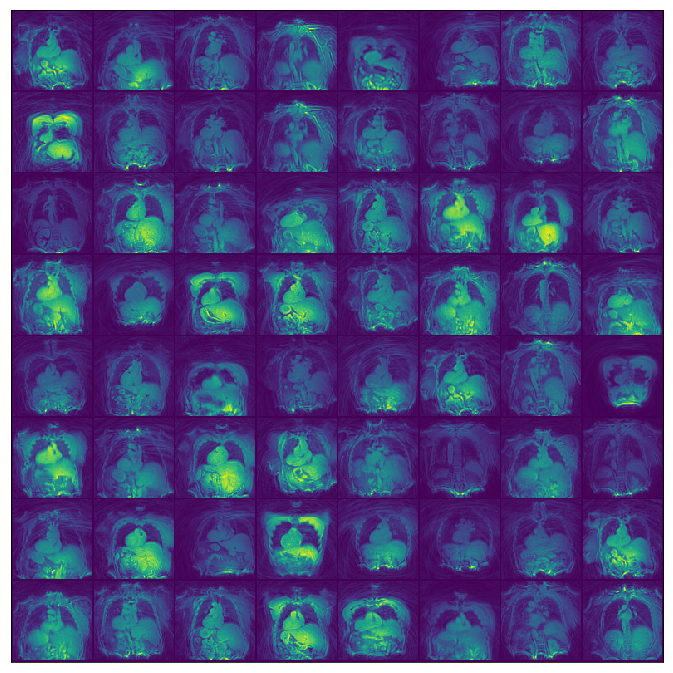

In [7]:
from torchvision.utils import make_grid
from data_prep.get_stats import denormalize, clamp0To1

def show_batch(dl):
    for batch in dl:
        images, labels = batch
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        regular_images = clamp0To1(images) #denormalize(images, mean, std)
        ax.imshow(make_grid(regular_images, nrow=8)[0])
        break

show_batch(train_dl)

In [8]:
# Move everything onto the GPU

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = get_default_device()
print(device)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

cuda


In [11]:
"""
We can either train the model from scratch or load a previously trained model from a file. Note that the file must contain
the params for a model with the exact same architecture. Set trainModel = True to train from scratch.
"""

from train import train_net
from unet import UNet

model = UNet(n_channels=1, n_classes=2)
model = to_device(model, device)
torch.cuda.empty_cache()

trainModel = False

if trainModel:
    epochs=200
    learning_rate = 2.3575468270991194e-06
    weight_decay = 0.0003 # 1.0627305764652195e-06 # 1e-8
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    # scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda lr: 1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)
    dice = train_net(model, train_ds, train_dl, valid_dl, batch_size, optimizer, scheduler, None, valid_percent, epochs=epochs, lr=learning_rate, 
                     device=device, save_checkpoint=True, amp=False)
    print(f"Average Dice Coefficient across the validation set: {dice:.3f}")
else:
    modelPath = './model_params/UNet-0.923-2022-03-31.pth'
    model.load_state_dict(torch.load(modelPath))

In [ ]:
# Let's plot some segmentations to get a feel for it

# Create a copy of the validation set with filenames available
dataset_with_filenames = NiftiDataset2D(reconPath, bitmaskPath, normalize=False, transform=tfms, bitmask_tfms=bitmask_tfms, rotate=270, includeFilename=True)
random_seed = 42
torch.manual_seed(random_seed)
_, valid_ds_with_filenames = random_split(dataset_with_filenames, [train_size, valid_size], generator=torch.Generator().manual_seed(random_seed))

valid_dl_with_filenames = DataLoader(valid_ds_with_filenames, batch_size, shuffle=True, num_workers=0, pin_memory=True)
# valid_dl_with_filenames = DeviceDataLoader(valid_dl_with_filenames, device)
model_cpu = to_device(model, torch.device('cpu'))

In [ ]:
from utils.dice_score import dice_coeff
import medpy.metric

for images, masks in valid_dl:
    images = images.float()
    masks = masks.float()
    masks_pred = model(images)
    total_assd = 0
    # for idx in range(39):
    idx = next(iter(range(39)))
    print(f"Image index: {idx}")
    image, mask, pred = images[idx, :, :, :].cpu(), masks[idx, 0, :, :].cpu(), masks_pred[idx, 0, :, :].cpu()
    image = image.squeeze()
    mask = mask.squeeze()
    pred_noSig = pred
    pred = (torch.sigmoid(pred) > 0.5).float()
    dice = dice_coeff(mask, pred)
    assd = medpy.metric.binary.assd(pred.numpy(), mask.numpy())
    total_assd += assd
    pred = pred.squeeze().detach().numpy()
    pred_noSig = pred_noSig.squeeze().detach().numpy()

    # print(filenames[idx])
    print(f'Dice Score: {dice:.3f}')
    print(f"ASSD: {assd}")

    numPlots = 4
    plt.rcParams['figure.figsize'] = [12, 4]
    fig, ax = plt.subplots(1, numPlots)
    fig.tight_layout()
    ims = [image, mask, pred, pred_noSig]
    titles = ["Image", "Ground Truth", "Segmentation", "Segmentation no Sigmoid"]
    for i in range(numPlots):
        ax[i].imshow(ims[i])
        ax[i].title.set_text(titles[i])
    fig.suptitle(f"DSC = {dice:.3f}     ASSD = {assd:.4f}")
    fig.subplots_adjust(top=1.0)

    # Save the figure to a file (Needs a pics folder to exist in the main directory)
    #plt.savefig('./pics/'+str(dice.item())+'_'+str(assd)+'.png')
    break


If we don't yet know which hyperparameters work best, we can do a hyperparameter search with optuna. We'll search across various learning rates as well as a few different optimizers, loss functions and learning rate schedulers.

In [13]:
import optuna
from optuna import trial
from train import train_net

def optunaObjective(trial: trial, train_ds=train_ds, train_dl=train_dl, valid_dl=valid_dl):
    # torch.cuda.empty_cache() # Probably not necessary
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Set hyperparameters
    config = {
    "lr": trial.suggest_float("lr", 1e-6, 1e-2, log=True),
    "optimizer": trial.suggest_categorical("optimizer", ["SGD", "Adam", "RMSprop"]),
    "weight_decay": trial.suggest_float("weight_decay", 1e-10, 1e-1, log=True),
    "lr_scheduler": trial.suggest_categorical("lr_scheduler", ["ReduceLROnPlateau", "OneCycleLR", "LambdaLR"]),
    "loss_function": trial.suggest_categorical("loss_function", ["CrossEntropyLoss", "DiceLoss", "CrossEntropy+DiceLoss"])
    }

    # Initialize neural net model
    model = UNet(n_channels=1, n_classes=2)
    model = to_device(model, device)
    torch.cuda.empty_cache()
    epochs = 75
    batch_size = 64

    # Create optimizer
    if config["optimizer"] == "RMSprop":
        optimizer = getattr(torch.optim, config["optimizer"])(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"], momentum=0.9)
    else:
        optimizer = getattr(torch.optim, config["optimizer"])(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"]) # no momentum
    
    # Create learning rate scheduler -- they all need different arguments
    if config["lr_scheduler"] == "ReduceLROnPlateau":
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    elif config["lr_scheduler"] == "OneCycleLR":
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, config["lr"], epochs=epochs, steps_per_epoch=len(train_dl))
    elif config["lr_scheduler"] == "LambdaLR":
        lambda1 = lambda lr: 1
        lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)    # lr doesn't change ever if lr_lambda=1

    # Loss function will be set inside the training loop

    accuracy = train_net(model, train_ds, train_dl, valid_dl, batch_size, optimizer, lr_scheduler, config["loss_function"],
                         valid_percent, epochs=epochs, lr=config["lr"], device=device, save_checkpoint=True, amp=False)
    
    return accuracy
    

In [ ]:
torch.cuda.empty_cache()
study = optuna.create_study(direction="maximize")
study.optimize(optunaObjective, n_trials=150)

In [21]:
print(f" Best Average Dice Score Achieved: {study.best_value}")
print("Hyperparameters used:")
study.best_params

 Best Average Dice Score Achieved: 0.9233770966529846
Hyperparameters used:


{'loss_function': 'CrossEntropyLoss',
 'lr': 3.095720393401075e-05,
 'lr_scheduler': 'ReduceLROnPlateau',
 'optimizer': 'RMSprop',
 'weight_decay': 6.018741572579814e-05}